# Purpose

To download the metasploit JSON file and add a column to the CVE processed JSON file indicating for which CVEs there is a known metasploit exploit

In [199]:
import urllib.request
import json
import re
import pandas as pd
import numpy as np
import datetime
import dateutil
from scipy.stats import ttest_rel
from sklearn import preprocessing


import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
FILE_LOC = 'https://raw.githubusercontent.com/rapid7/metasploit-framework/master/db/modules_metadata_base.json'
METASPLOIT_RAW = '../../data/raw/metasploit.json'
CVE_PROCESSED = '../../data/processed/cves.json'
CVE_METASPLOIT_PROCESSED = '../../data/processed/cves_metasploit.json'

In [70]:
response = urllib.request.urlopen(FILE_LOC)
raw_file =  response.read()

with open(METASPLOIT_RAW, 'wb') as fout:
    fout.write(raw_file)
print("wrote metasploit.json")

wrote metasploit.json


In [71]:
# read metasploit file
with open(METASPLOIT_RAW, 'r') as fin:
    metasploit = json.loads(fin.read())

In [234]:
# read cve file as pandas
cves_df = pd.read_json(CVE_PROCESSED)
display(cves_df.head())

# add metasploit column set to 0
cves_df['metasploit'] = 0
cves_df['metasploit_date'] = ''

cves_df.head()

,access,authentication,availability,complexity,confidentiality,date,id,integrity,v2,v3
0,NETWORK,NONE,PARTIAL,LOW,NONE,1999-12-30,CVE-1999-0001,NONE,1,0
1,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1998-10-12,CVE-1999-0002,COMPLETE,1,0
2,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1998-04-01,CVE-1999-0003,COMPLETE,1,0
3,NETWORK,NONE,PARTIAL,LOW,NONE,1997-12-16,CVE-1999-0004,NONE,1,0
4,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1998-07-20,CVE-1999-0005,COMPLETE,1,0


,access,authentication,availability,complexity,confidentiality,date,id,integrity,v2,v3,metasploit,metasploit_date
0,NETWORK,NONE,PARTIAL,LOW,NONE,1999-12-30,CVE-1999-0001,NONE,1,0,0,
1,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1998-10-12,CVE-1999-0002,COMPLETE,1,0,0,
2,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1998-04-01,CVE-1999-0003,COMPLETE,1,0,0,
3,NETWORK,NONE,PARTIAL,LOW,NONE,1997-12-16,CVE-1999-0004,NONE,1,0,0,
4,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1998-07-20,CVE-1999-0005,COMPLETE,1,0,0,


In [235]:
# Search metasploit's db for CVE references and set the metasploit and metasploit_date if matched
cve_regx = re.compile(r'CVE-\d{4}-\d{4,7}')
total = len(metasploit)
count = 0
for key, item in metasploit.items():
    for reference in item['references']:
        match = cve_regx.match(reference)
        if match:
            matched_cve = match.group()
            matched = cves_df.loc[cves_df['id']==matched_cve, ['metasploit', 'metasploit_date']] = 1, item['disclosure_date']
            
    count += 1
    print("\r{0:.2f} Complete...".format(count*100/total), end='')

100.00 Complete...

In [236]:
cves_df['date'] = pd.to_datetime(cves_df['date'])
cves_df['metasploit_date'] = pd.to_datetime(cves_df['metasploit_date'])
cves_df['report_delay'] = cves_df['metasploit_date'] - cves_df['date']

cves_df = cves_df[['id', 'v2', 'v3', 'access', 'authentication', 'complexity', 'confidentiality', 'integrity', 'availability', 'date', 'metasploit_date', 'report_delay', 'metasploit']].sort_values('date').reset_index(drop=True)
cves_df.head()

,id,v2,v3,access,authentication,complexity,confidentiality,integrity,availability,date,metasploit_date,report_delay,metasploit
0,CVE-1999-0095,1,0,NETWORK,NONE,LOW,COMPLETE,COMPLETE,COMPLETE,1988-10-01,NaT,NaT,0
1,CVE-1999-0082,1,0,NETWORK,NONE,LOW,COMPLETE,COMPLETE,COMPLETE,1988-11-11,NaT,NaT,0
2,CVE-1999-1471,1,0,LOCAL,NONE,LOW,COMPLETE,COMPLETE,COMPLETE,1989-01-01,NaT,NaT,0
3,CVE-1999-1122,1,0,LOCAL,NONE,LOW,PARTIAL,PARTIAL,PARTIAL,1989-07-26,NaT,NaT,0
4,CVE-1999-1467,1,0,NETWORK,NONE,LOW,COMPLETE,COMPLETE,COMPLETE,1989-10-26,NaT,NaT,0


In [232]:
cves_df[cves_df['metasploit_date'].notnull()]['report_delay'].describe()

count                         1536
mean     -66 days +04:24:22.500000
std       398 days 14:36:57.471799
min           -3326 days +00:00:00
25%             -37 days +00:00:00
50%              -5 days +00:00:00
75%              -1 days +00:00:00
max             4465 days 00:00:00
Name: report_delay, dtype: object

In [85]:
cves_df[cves_df['report_delay']<datetime.timedelta(0)]

,access,authentication,availability,complexity,confidentiality,date,id,integrity,v2,v3,metasploit,metasploit_date,report_delay
960,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1999-07-19,CVE-1999-1011,COMPLETE,1,0,1,1998-07-17,-367 days
1787,NETWORK,NONE,COMPLETE,LOW,COMPLETE,2000-04-24,CVE-2000-0248,COMPLETE,1,0,1,2000-04-04,-20 days
1861,NETWORK,NONE,COMPLETE,LOW,COMPLETE,2000-04-24,CVE-2000-0322,COMPLETE,1,0,1,2000-04-04,-20 days
2110,NETWORK,NONE,COMPLETE,LOW,COMPLETE,2000-07-07,CVE-2000-0573,COMPLETE,1,0,1,2000-06-22,-15 days
2447,NETWORK,NONE,COMPLETE,LOW,COMPLETE,2000-12-19,CVE-2000-0917,COMPLETE,1,0,1,2000-09-25,-85 days
2475,NETWORK,NONE,COMPLETE,LOW,COMPLETE,2000-12-19,CVE-2000-0945,COMPLETE,1,0,1,2000-10-26,-54 days
2618,NETWORK,NONE,COMPLETE,LOW,COMPLETE,2001-01-09,CVE-2000-1089,COMPLETE,1,0,1,2000-12-04,-36 days
2737,NETWORK,NONE,COMPLETE,LOW,COMPLETE,2002-08-12,CVE-2000-1209,COMPLETE,1,0,1,2000-05-30,-804 days
2928,LOCAL,NONE,NONE,LOW,PARTIAL,2001-05-03,CVE-2001-0152,NONE,1,0,1,2001-03-27,-37 days
2941,NETWORK,NONE,COMPLETE,HIGH,COMPLETE,2001-05-03,CVE-2001-0167,COMPLETE,1,0,1,2001-01-29,-94 days


In [86]:
cves_pos_df = cves_df[cves_df['report_delay']>=datetime.timedelta(0)]
cves_neg_df = cves_df[cves_df['report_delay']<datetime.timedelta(0)]

In [87]:
cves_neg_df['date'].count()

1248

In [88]:
cves_pos_df['date'].count()

288

In [89]:
out = cves_df.to_json(orient='records')
with open(CVE_METASPLOIT_PROCESSED, 'w') as fout:
    fout.write(out)


In [90]:
cves_df = cves_df.sort_values(by='date')
cves_df['year'] = cves_df['date'].dt.year
cves_df.head()

,access,authentication,availability,complexity,confidentiality,date,id,integrity,v2,v3,metasploit,metasploit_date,report_delay,year
93,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1988-10-01,CVE-1999-0095,COMPLETE,1,0,0,NaT,NaT,1988
80,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1988-11-11,CVE-1999-0082,COMPLETE,1,0,0,NaT,NaT,1988
1417,LOCAL,NONE,COMPLETE,LOW,COMPLETE,1989-01-01,CVE-1999-1471,COMPLETE,1,0,0,NaT,NaT,1989
1069,LOCAL,NONE,PARTIAL,LOW,PARTIAL,1989-07-26,CVE-1999-1122,PARTIAL,1,0,0,NaT,NaT,1989
1413,NETWORK,NONE,COMPLETE,LOW,COMPLETE,1989-10-26,CVE-1999-1467,COMPLETE,1,0,0,NaT,NaT,1989


3320.8709677419356

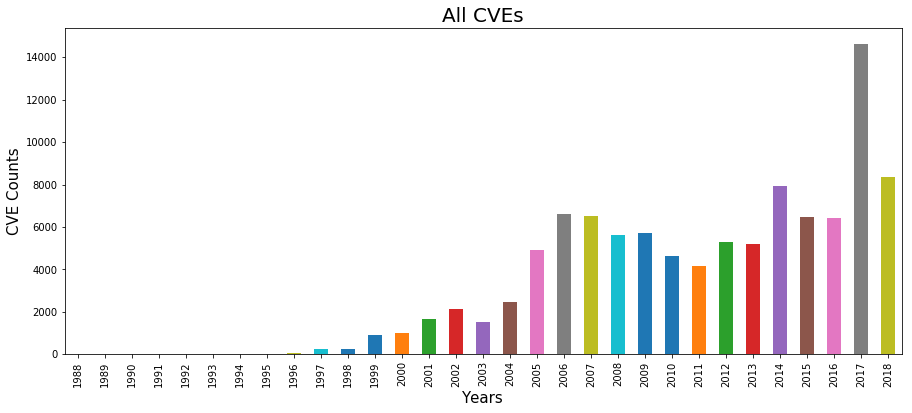

In [184]:
plt.rcParams['figure.figsize'] = 15,6
#plt.rcParams['figure.figsize'] = 8, 4
title_size=20
labelsize=15
ticksize=10

# plot the number of vulnerabilities by year
cves_df.groupby('year')['year'].size().plot(kind='bar')
plt.title('All CVEs', fontsize=title_size)
plt.xlabel('Years', fontsize=labelsize)
plt.ylabel('CVE Counts', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/all_cve_bar.png')

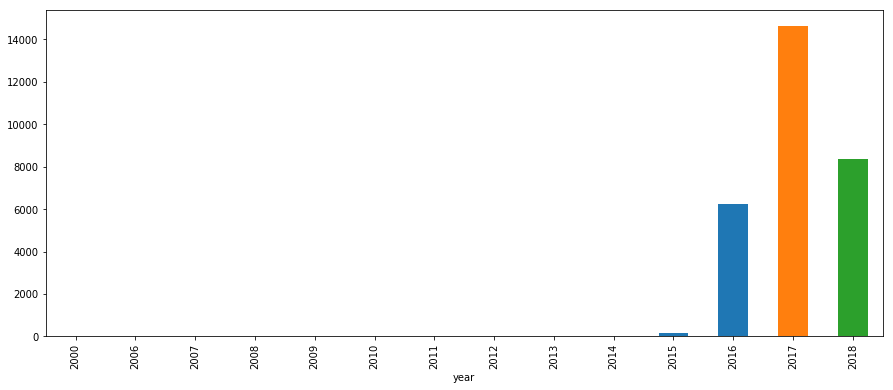

In [185]:
# now plot the number of v3 vulnerabilities by year
cves_df[cves_df['v3']==1].groupby('year').size().plot(kind='bar')

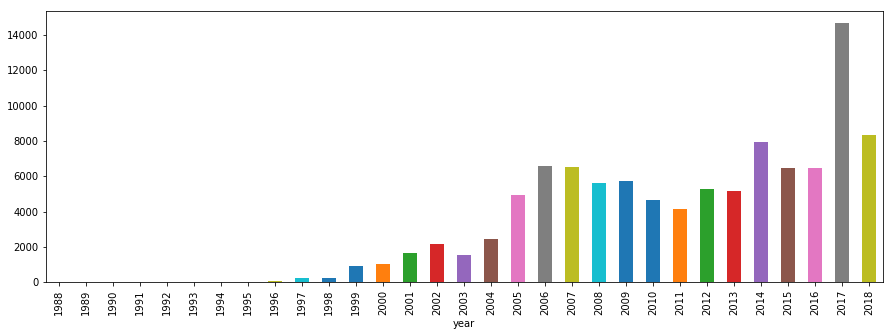

In [163]:
# and the number of v2 vulnerabilities
cves_df[cves_df['v2']==1].groupby('year').size().plot(kind='bar')

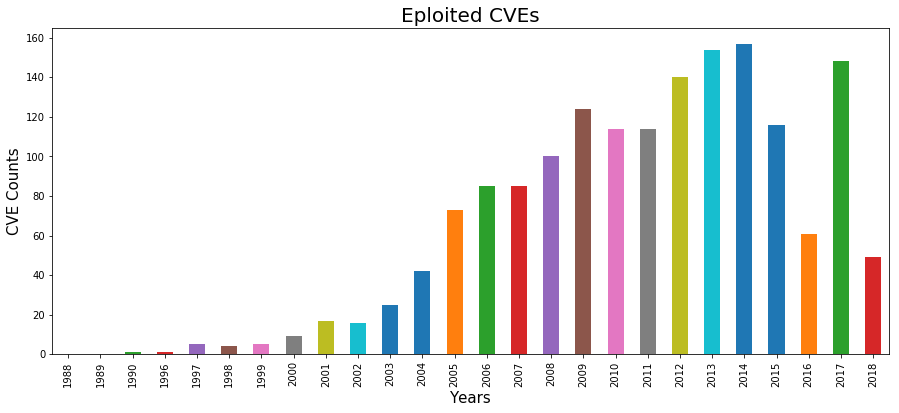

In [194]:
# plot exploits per year
data = cves_df[cves_df['metasploit']==1].groupby('year').size()
data[1988] = 0
data[1989] = 0
data = data.sort_index()
data.plot(kind='bar')
plt.title('Eploited CVEs', fontsize=title_size)
plt.xlabel('Years', fontsize=labelsize)
plt.ylabel('CVE Counts', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/exploited_cve_bar.png')

We see that the distribution of vulnerabilities closlely matches the v2 frequency as we would expect since they should be the exact same population, lol, we will do a t-test just to verify,

then we will do one to see whether exploits differ greatly from vulnerabilities

In [152]:
cves_df[cves_df['v2']==1].groupby('year').size().isnull().values.any()

False

In [154]:
# for a paired-t-test this fails since both distributions have the same variance and cause a div-0: 
# https://stats.stackexchange.com/questions/223579/what-do-you-expect-a-2-sample-t-test-for-the-same-two-samples-to-return
ttest_rel(
    cves_df.groupby('year')['year'].size(), 
    cves_df[cves_df['v2']==1].groupby('year').size()
)

C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\capstone\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\capstone\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\capstone\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Ttest_relResult(statistic=nan, pvalue=nan)

In [158]:
# now lets check for metasploit=1 (exploits), these start consistently in 1996, so we will limit our results from there
ttest_rel(
    cves_df[(cves_df['metasploit']==1) & (cves_df['year']>=1996)].groupby('year').size(),
    cves_df[cves_df['year']>=1996].groupby('year')['year'].size()
)

# well now, looks like we have some statistical signifiance, the frequency of exploits is not directly porportional to the
# frequency of vulnerabilities

Ttest_relResult(statistic=-6.246217430052529, pvalue=2.7543493129238434e-06)

In [210]:
a = cves_df[(cves_df['metasploit']==1) & (cves_df['year']>=1996)].groupby('year').size()
b = cves_df[cves_df['year']>=1996].groupby('year')['year'].size()


a_norm = (a - a.mean()) / (a.max() - a.min())
b_norm = (b - b.mean()) / (b.max() - b.min())


# now lets check for metasploit=1 (exploits), these start consistently in 1996, so we will limit our results from there
ttest_rel(
    a_norm,
    b_norm
)

# further research shows that correlation is probably a better measure

Ttest_relResult(statistic=-1.5001759862306438e-16, pvalue=0.9999999999999999)

In [211]:
a.corr(b)


0.7580480223867418

# Looking at Attributes

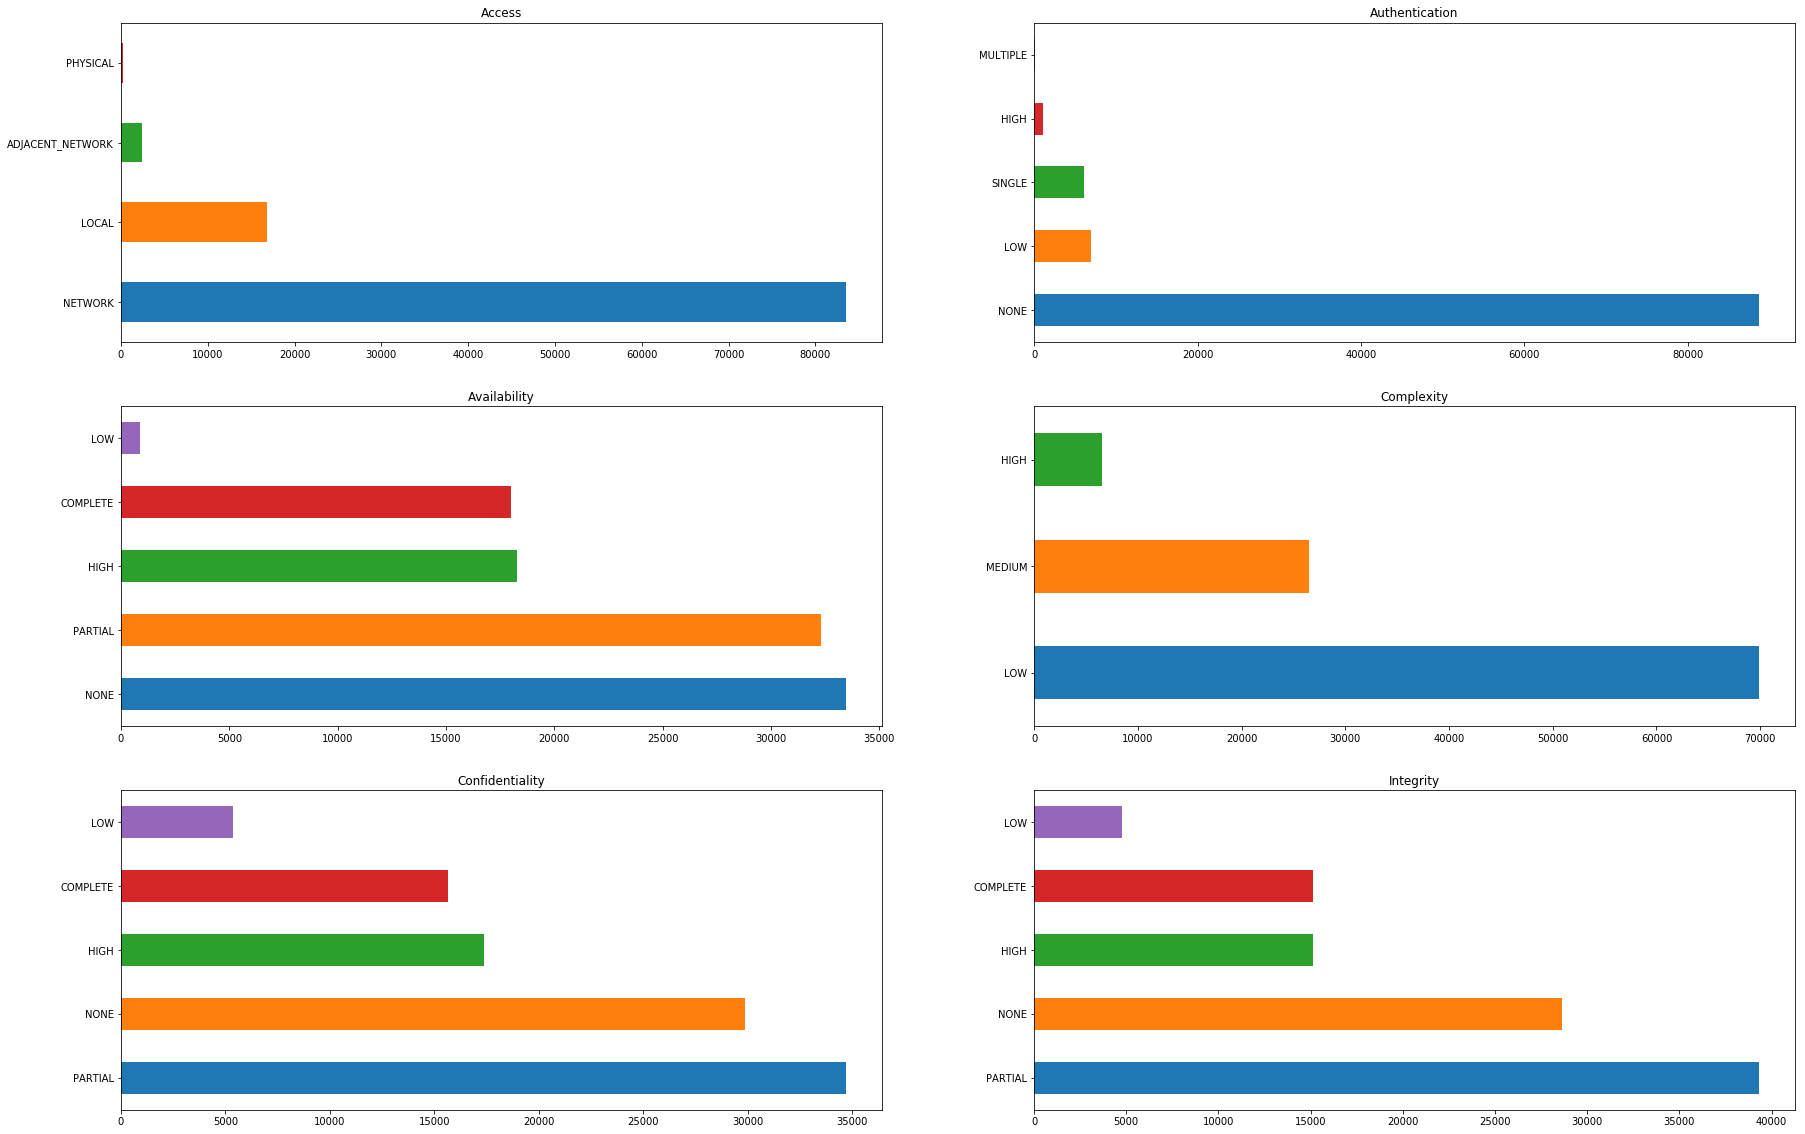

In [27]:
plt.rcParams['figure.figsize'] = 30, 20
plt.subplot(3, 2, 1)
cves_df['access'].value_counts().plot(kind='barh', title='Access')

plt.subplot(3, 2, 2)
cves_df['authentication'].value_counts().plot(kind='barh', title='Authentication')

plt.subplot(3, 2, 3)
cves_df['availability'].value_counts().plot(kind='barh', title='Availability')

plt.subplot(3, 2, 4)
cves_df['complexity'].value_counts().plot(kind='barh', title='Complexity')

plt.subplot(3, 2, 5)
cves_df['confidentiality'].value_counts().plot(kind='barh', title='Confidentiality')

plt.subplot(3, 2, 6)
cves_df['integrity'].value_counts().plot(kind='barh', title='Integrity')

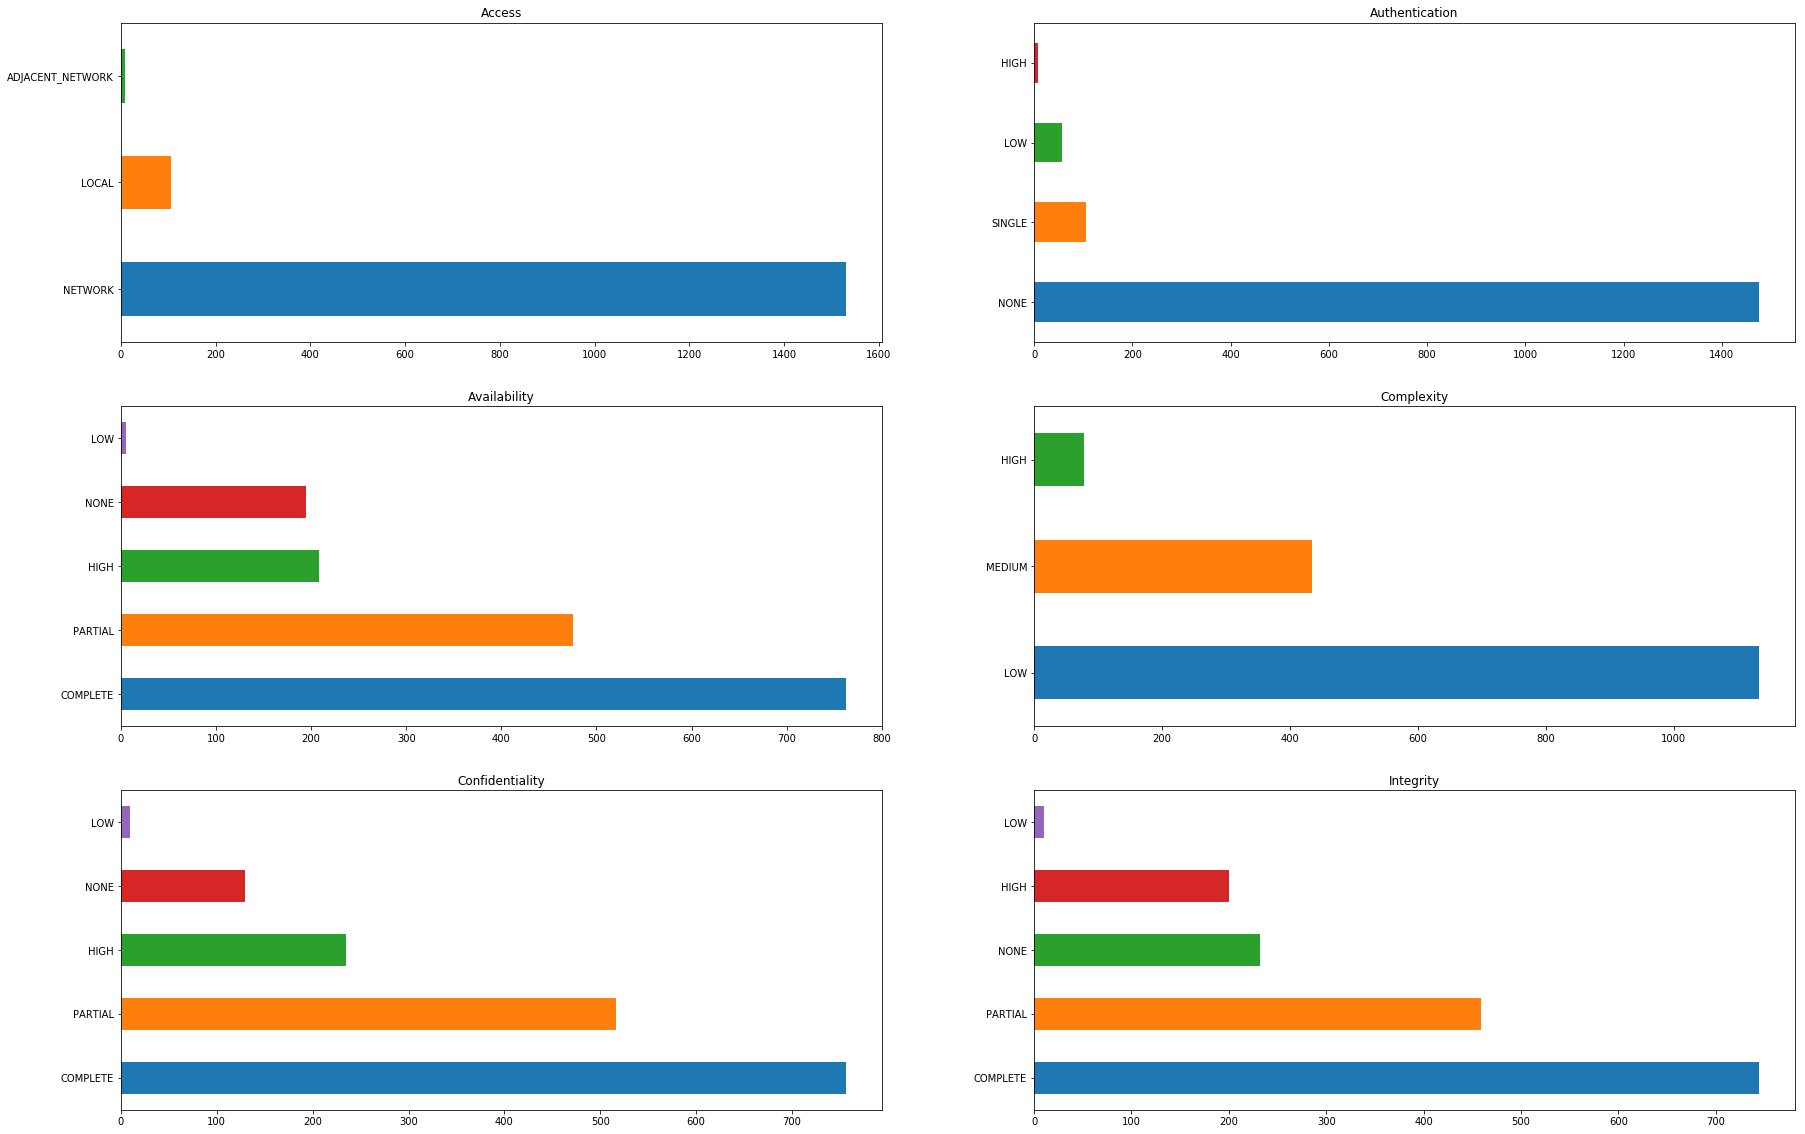

In [30]:
plt.rcParams['figure.figsize'] = 30, 20
plt.subplot(3, 2, 1)
cves_df[cves_df['metasploit']==1]['access'].value_counts().plot(kind='barh', title='Access')

plt.subplot(3, 2, 2)
cves_df[cves_df['metasploit']==1]['authentication'].value_counts().plot(kind='barh', title='Authentication')

plt.subplot(3, 2, 3)
cves_df[cves_df['metasploit']==1]['availability'].value_counts().plot(kind='barh', title='Availability')

plt.subplot(3, 2, 4)
cves_df[cves_df['metasploit']==1]['complexity'].value_counts().plot(kind='barh', title='Complexity')

plt.subplot(3, 2, 5)
cves_df[cves_df['metasploit']==1]['confidentiality'].value_counts().plot(kind='barh', title='Confidentiality')

plt.subplot(3, 2, 6)
cves_df[cves_df['metasploit']==1]['integrity'].value_counts().plot(kind='barh', title='Integrity')

* Access is overwhealmingly Network based for both exploited and non exploited
* Authentication is mostly none for both exploited and non-exploited
* Availability is mostly Complete and Partial for exploited while non-exploited is mostly none and partial, which may imply that vulnerabilities that have something to offer are more likely to be exploited
* Complexity also follows the non-exploited distribution
* Confidentiality exploits seem to favor complete and partial over the non-exploited none and partial, again potentially implying that exploits are targeted towards systems that can provide value
* Integrity is also in favor of complete and partial over partial and none

In [238]:
plt.rcParams['figure.figsize'] = 8, 4
title_size=20
labelsize=10
ticksize=10

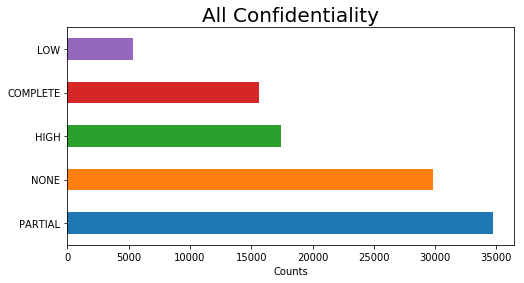

In [239]:
cves_df['confidentiality'].value_counts().plot(kind='barh')
plt.title('All Confidentiality', fontsize=title_size)
plt.xlabel('Counts', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/confidentiality_all.png')

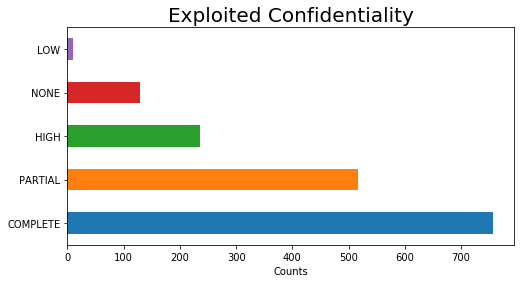

In [240]:
cves_df[cves_df['metasploit']==1]['confidentiality'].value_counts().plot(kind='barh')
plt.title('Exploited Confidentiality', fontsize=title_size)
plt.xlabel('Counts', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/confidentiality_exploited.png')

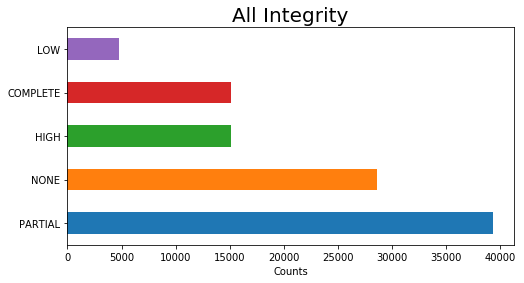

In [241]:
cves_df['integrity'].value_counts().plot(kind='barh')
plt.title('All Integrity', fontsize=title_size)
plt.xlabel('Counts', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/integrity_all.png')

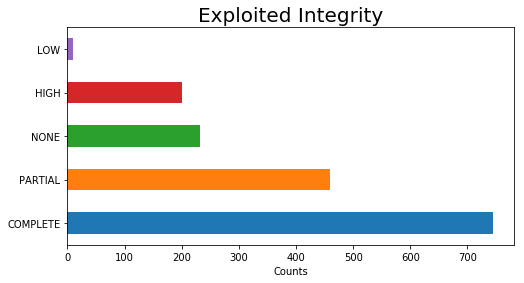

In [242]:
cves_df[cves_df['metasploit']==1]['integrity'].value_counts().plot(kind='barh')
plt.title('Exploited Integrity', fontsize=title_size)
plt.xlabel('Counts', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/integrity_exploited.png')

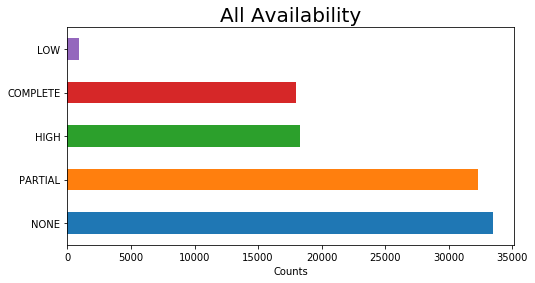

In [243]:
cves_df['availability'].value_counts().plot(kind='barh')
plt.title('All Availability', fontsize=title_size)
plt.xlabel('Counts', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/availability_all.png')

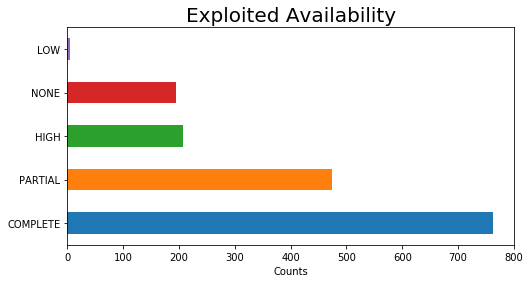

In [244]:
cves_df[cves_df['metasploit']==1]['availability'].value_counts().plot(kind='barh')
plt.title('Exploited Availability', fontsize=title_size)
plt.xlabel('Counts', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/availability_exploited.png')

exploits counts go up over the years, as we've seen in some datasets, exploits are not always reported right away, which may account for the drop from 2016-2018